* It's a multiclass Classification task.
* 1. Load & Preprocess Data (image resizing, label encoding)
* 2. Train-Test Split
* 3. Build CNN Model (lightweight & accurate)
* 4. Train the Model (with callbacks)
* 5. Evaluate & Visualize


# Step 1: Import Libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import tensorflow as tf


2025-06-28 10:35:34.364702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751106934.524843      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751106934.574917      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Step 2: Set Dataset Path

In [2]:
IMG_SIZE = 128
DATA_PATH = "/kaggle/input/leapgestrecog/leapGestRecog/"

X = []
y = []

for person in os.listdir(DATA_PATH):
    person_path = os.path.join(DATA_PATH, person)
    if not os.path.isdir(person_path):
        continue
    for gesture_folder in os.listdir(person_path):
        gesture_path = os.path.join(person_path, gesture_folder)
        if not os.path.isdir(gesture_path):
            continue
        gesture_name = gesture_folder.split('_', 1)[1]
        for img_file in os.listdir(gesture_path):
            img_path = os.path.join(gesture_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img)
            y.append(gesture_name)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
y = np.array(y)


# Step 3: Encoding and Splitting dataset

In [16]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

label_map = {i: label for i, label in enumerate(le.classes_)}
np.save('/kaggle/working/label_map.npy', label_map)
print("Label map saved as 'label_map.npy'")


X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, stratify=y, random_state=42)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Classes: {le.classes_}")


Label map saved as 'label_map.npy'
Train: (16000, 128, 128, 1), Test: (4000, 128, 128, 1)
Classes: ['c' 'down' 'fist' 'fist_moved' 'index' 'l' 'ok' 'palm' 'palm_moved'
 'thumb']


#  STEP 4: Augmentation Generator


In [4]:
train_aug = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Step 5: Create Validation Set and Generators


In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

train_generator = train_aug.flow(
    X_train, y_train, batch_size=64
)

val_generator = ImageDataGenerator().flow(
    X_val, y_val, batch_size=64
)

#  Step 6: CNN Model Architecture

In [6]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Flatten(),
    Dropout(0.6),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.4),
    Dense(len(le.classes_), activation='softmax', kernel_regularizer=regularizers.l2(0.001))
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1751107135.216975      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 30, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,306,250 (12.61 MB)

 Trainable params: 3,305,802 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

# Step 7: Train the Model with Callbacks


In [7]:

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

In [8]:
early_stop = EarlyStopping(
    patience=5,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    "leap_gesture_model.h5",
    save_best_only=True
)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stop, model_checkpoint]
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1751107140.561155     107 service.cc:148] XLA service 0x3faadf40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751107140.561882     107 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751107141.001744     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/200 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.1128 - loss: 5.8259

I0000 00:00:1751107145.865539     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - accuracy: 0.2479 - loss: 2.8826 - val_accuracy: 0.1000 - val_loss: 7.1174 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.6100 - loss: 1.5648 - val_accuracy: 0.2000 - val_loss: 8.3236 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.7928 - loss: 1.1127 - val_accuracy: 0.5075 - val_loss: 2.7377 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.8799 - loss: 0.9329 - val_accuracy: 0.7166 - val_loss: 2.1769 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.9178 - loss: 0.8795 - val_accuracy: 0.9553 - val_loss: 0.7433 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.9378 - loss: 0.8093 - val_accuracy: 0.9538 - val_loss: 0.7214 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.9496 - loss: 0.7493

# Step 8: Evaluate on Test Set


In [9]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9988 - loss: 0.2477
Test Loss: 0.2507, Test Accuracy: 0.9987


# Save the model

In [10]:
model.save("leap_gesture_model.h5")


# Step 9: Visualize Training History


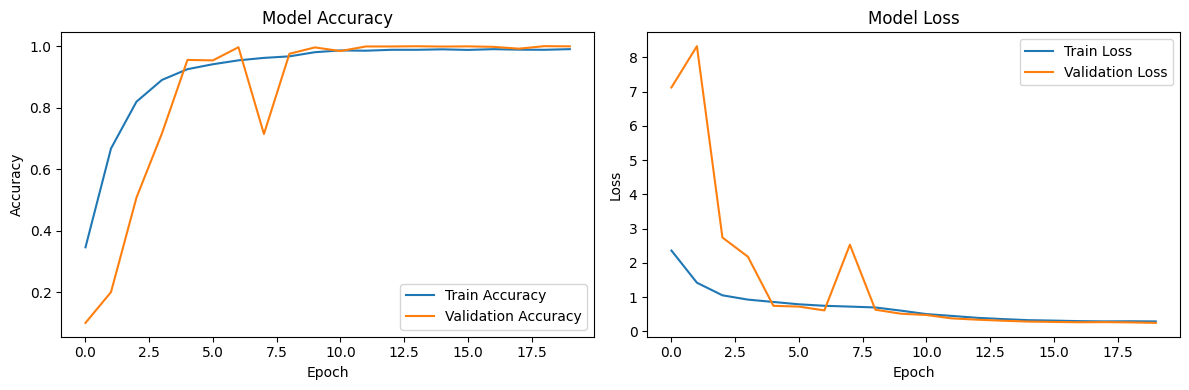

In [11]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Step 10: Analyze Per-Class Performance


In [12]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


# Confusion Matrix & Classification Report

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


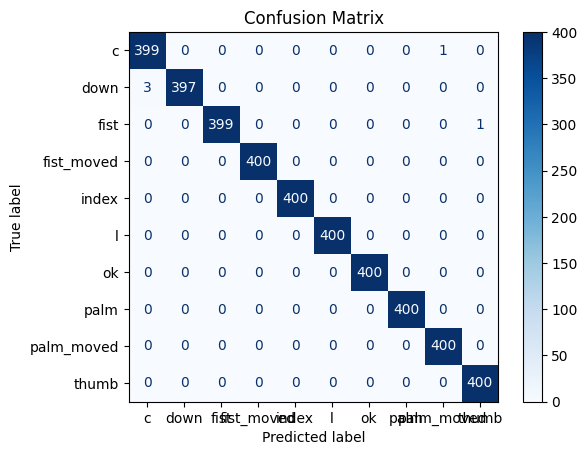

Classification Report:
              precision    recall  f1-score   support

           c       0.99      1.00      1.00       400
        down       1.00      0.99      1.00       400
        fist       1.00      1.00      1.00       400
  fist_moved       1.00      1.00      1.00       400
       index       1.00      1.00      1.00       400
           l       1.00      1.00      1.00       400
          ok       1.00      1.00      1.00       400
        palm       1.00      1.00      1.00       400
  palm_moved       1.00      1.00      1.00       400
       thumb       1.00      1.00      1.00       400

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))


# Step 11: Testing

In [19]:
model = load_model('leap_gesture_model.h5')

img = cv2.imread('/kaggle/input/leapgestrecog/leapGestRecog/00/05_thumb/frame_00_05_0001.png', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (128, 128))
img = img / 255.0
img = img.reshape(1, 128, 128, 1)

prediction = model.predict(img)
predicted_label = np.argmax(prediction)

print("Predicted Label Index:", predicted_label)
print("Predicted Gesture Name:", label_map[predicted_label])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
Predicted Label Index: 9
Predicted Gesture Name: thumb


# Step 12: Convert Model to TensorFlow Lite


In [20]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open('/kaggle/working/leap_gesture_model.tflite', 'wb') as f:
    f.write(tflite_model)
print("TensorFlow Lite model saved as 'leap_gesture_model.tflite'")

Saved artifact at '/tmp/tmpo0kmn07x'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133096505519248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133096505518864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133096498555472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133096498558736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133096505517136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133096498547408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133096498550672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133096498546832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133096498549520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133096498455824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13309649855777

W0000 00:00:1751107837.181366      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1751107837.181396      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
